In [1]:
import itertools as it
import typing

from nbmetalog import nbmetalog as nbm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from pylib import hanoi


In [2]:
nbm.print_metadata()


context: ci
hostname: fv-az975-85
interpreter: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
nbcellexec: null
nbname: retention-equivalence-tilted
nbpath: /home/runner/work/hstrat-surface-concept/hstrat-surface-concept/binder/retention-equivalence-tilted.ipynb
revision: null
session: 95953380-f14b-4063-9fea-502ba0db011f
timestamp: 2024-08-11T06:39:17Z00:00


IPython==7.31.1
keyname==0.5.2
yaml==6.0
matplotlib==3.8.3
nbmetalog==0.2.6
numpy==1.23.5
seaborn==0.13.2
re==2.2.1
comm==0.1.3
logging==0.5.1.2
psutil==5.9.5
zmq==25.1.0
json==2.0.9
ipykernel==6.23.3


## Define Set Construction


In [3]:
def filter_retained(reserved_per_hanoi: int, cur_time: int) -> typing.Set[int]:
    n = int(reserved_per_hanoi)  # handle numpy dtypes...
    T = int(cur_time)
    return {
        t
        for t in range(T + 1)
        if hanoi.get_incidence_count_of_hanoi_value_through_index(
            hanoi.get_hanoi_value_at_index(t), T
        )
        - 1
        - hanoi.get_hanoi_value_incidence_at_index(t)
        < n
    }


In [4]:
def construct_retained_abstracted(
    reserved_per_hanoi: int, cur_time: int
) -> typing.Set[int]:
    n = int(reserved_per_hanoi)  # handle numpy dtypes...
    T = int(cur_time)
    generator = filter(
        lambda t: t >= 0,
        (
            hanoi.get_hanoi_value_index_cadence(h)
            * (
                (T - hanoi.get_hanoi_value_index_offset(h))
                // hanoi.get_hanoi_value_index_cadence(h)
                - i
            )
            + hanoi.get_hanoi_value_index_offset(h)
            for h in range(hanoi.get_max_hanoi_value_through_index(T) + 1)
            for i in range(n)
        ),
    )
    return set(generator)


In [5]:
def construct_retained_naive(
    reserved_per_hanoi: int, cur_time: int
) -> typing.Set[int]:
    n = int(reserved_per_hanoi)  # handle numpy dtypes...
    T = int(cur_time)
    generator = filter(
        lambda t: t >= 0,
        (
            2 ** (h + 1) * ((T - 2**h + 1) // 2 ** (h + 1) - i) + 2**h - 1
            for h in range(hanoi.get_max_hanoi_value_through_index(T) + 1)
            for i in range(n)
        ),
    )
    return set(generator)


In [6]:
def construct_retained_distilled(
    reserved_per_hanoi: int, cur_time: int
) -> typing.Set[int]:
    n = int(reserved_per_hanoi)  # handle numpy dtypes...
    T = int(cur_time)
    generator = filter(
        lambda t: t >= 0,
        (
            2**h * ((T + 1) // 2**h - i) - 1
            for h in range(hanoi.get_max_hanoi_value_through_index(T) + 1)
            for i in range(2 * n)
        ),
    )
    return set(generator)


In [7]:
def calc_distilled2naive(h: int, i: int, T: int, n: int) -> int:
    distilled = 2**h * ((T + 1) // 2**h - i) - 1
    if distilled < 0 or distilled > T:
        return -1

    H = hanoi.get_hanoi_value_at_index(distilled)
    assert H >= h

    Z = ((T - 2**H + 1) // 2 ** (h)) / 2 ** (H + 1 - h) - (
        (T - 2**H + 1) // 2 ** (H + 1)
    )
    assert 0 <= Z < 1

    assert (Z - i / 2 ** (H - h + 1)).is_integer()
    assert 0 <= -(Z - i / 2 ** (H - h + 1)) < n

    return (
        2 ** (H + 1)
        * (((T - 2**H + 1) // 2 ** (H + 1)) + Z - i / 2 ** (H - h + 1))
        + 2**H
        - 1
    )


def construct_retained_distilled2naive(
    reserved_per_hanoi: int, cur_time: int
) -> typing.Set[int]:
    n = int(reserved_per_hanoi)  # handle numpy dtypes...
    T = int(cur_time)
    generator = filter(
        lambda t: t >= 0 and t <= T,
        (
            calc_distilled2naive(h, i, T, n)
            for h in range(hanoi.get_max_hanoi_value_through_index(T) + 1)
            for i in range(2 * n)
        ),
    )
    return set(generator)


## Visualize Constructed Sets


In [8]:
def plot_retained(retained: typing.Set[int], T: int) -> plt.Axes:
    ax = sns.rugplot(list(retained), height=1.0)
    ax.figure.set_size_inches(7, 1)
    ax.yaxis.set_visible(False)
    ax.axvline(x=T, color="black", linewidth=2, ls=":")
    ax.set_xlim(-1, T + 1)
    return ax


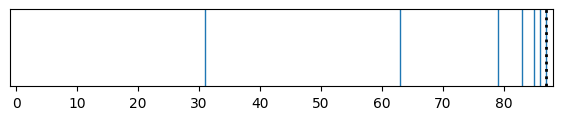

n=1, T=87, len(retained)=7
[31, 63, 79, 83, 85, 86, 87]



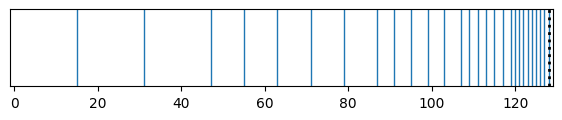

n=5, T=128, len(retained)=28
[15, 31, 47, 55, 63, 71, 79, 87, 91, 95, 99, 103, 107, 109, 111, 113, 115, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]



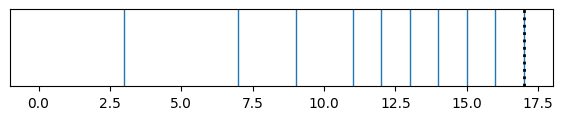

n=3, T=17, len(retained)=10
[3, 7, 9, 11, 12, 13, 14, 15, 16, 17]



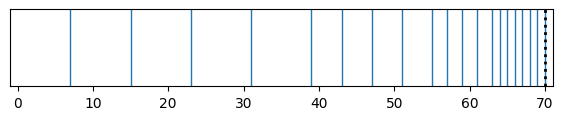

n=4, T=70, len(retained)=20
[7, 15, 23, 31, 39, 43, 47, 51, 55, 57, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70]



In [9]:
for n, T in [(1, 87), (5, 128), (3, 17), (4, 70)]:
    retained = construct_retained_distilled(n, T)
    plot_retained(retained, T)
    plt.show()
    print(f"n={n}, T={T}, len(retained)={len(retained)}")
    print(sorted(retained))
    print()


## Test Set Construction Equivalence


In [10]:
for n, T in tqdm(
    it.chain(
        it.product(
            range(100),
            range(100),
        ),
        zip(
            np.random.RandomState(seed=1).randint(500, size=2000),
            np.random.RandomState(seed=1).randint(100, 10001, size=2000),
        ),
    ),
    total=100 * 100 + 2000,
):
    assert (
        filter_retained(n, T)
        == construct_retained_abstracted(n, T)
        == construct_retained_naive(n, T)
        == construct_retained_distilled(n, T)
        == construct_retained_distilled2naive(n, T)
    )


100%|██████████| 12000/12000 [01:08<00:00, 174.68it/s]
